# Exercise 4: Ball-and stick neuron: Rall versus Eccles.

In this exercise you will use `NEURON` together with its `Python` interface. (If you are not familiar with `NEURON` and `Python` it might help to have a look at this site, which contains quite similar code to what we will be using: http://paedia.info/quickstart/pyneuron.html}).

You will be given example code (below) containing a ball-and-stick neuron, and a (virtual) patch clamp electrode that is used to inject a pulse current into the soma of the cell.

__(i)__ We have (what we will pretend to be) experimental data from current injection into the soma of a neuron. The current injection starts at $t$=10 ms, and is held constant throughout the recording (200 ms). In Figure 1 you can see the _charging curve_, i.e., how the voltage responds to the injected current, and moves from its initial resting state of -65 mV, towards its new resting state at a more depolarized potential. This type of recording has been used to estimate the membrane time constant of neurons, and a dispute in neuroscience in the 1950s, was whether the dendrites  of the neuron had a substantial impact on this charging curve. The group of [John Eccles](http://en.wikipedia.org/wiki/John_Eccles) used a lone soma model to fit the charging curve, while [Wilfred Rall](http://en.wikipedia.org/wiki/Wilfrid_Rall) and Figure 2) argued for using a ball-and-stick model. In this exercise you will try to solve the dispute by comparing the normalized charging curves from our
virtual 'experimental data' both to predictions from a lone soma model and from a ball-and-stick model. For more background information see Box 2.7 in Sterratt.

Use and modify the code in below to explore by visual inspection of the results whether the lone-soma model or the ball-and-stick model fit the (virtual) experimental data best. 

<img src="exercise_4_exp.png" width = "400">
__Figure 1:__ The charging curve of the soma in our (virtual) experimental neuron, following the injection of a constant current starting at $t$ = 10 ms.

<img src="RnG.png" width = "400">
__Figure 2:__ Gaute and his hero Wilfred Rall at the SfN meeting in Washington DC in 2014.


__(ii)__ Dendrites filter the incoming currents from other neuron, that is, _synaptic currents_.Here we will look at how synaptic currents, modeled here as a square current pulse with a duration of 5 milliseconds, are filtered by the ball-and-stick neuron. 

Modify the stimulation duration in the code below and explore how the voltage response in the soma to this stimulus depends on the position of the current stimulation along the ball-and-stick dendrite. What happens to the somatic response as the input is moved farther away?

__(iii) [Optional]__ If you would like to get more familiar with the Hodgkin-Huxley model, you can insert these conductances by simply writing `insert('hh')` instead of the already present `insert('pas')}` (The `'hh'` contains its own passive mechanism). You should now be able to make the model spike.

In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import neuron
nrn = neuron.h

In [75]:
def return_ball_soma(model='pas'):
    """
    Makes a ball-and-stick neuron model.
    :return: soma and dendrite NEURON objects. Both must be returned, or they are lost.
    """

    soma = nrn.Section('soma')
    soma.L = 15  # um; stored as a float number
    soma.diam = 15  # um
    soma.nseg = 100  # stored as an integer
    
    for sec in nrn.allsec():
        sec.insert(model)
        sec.Ra = 100
        sec.cm = 1
        if model=='pas':
            for seg in sec:
                seg.g_pas = 0.00003
                seg.e_pas = -65
            
    return soma

In [84]:
def return_ball_and_stick_soma(model='pas'):
    """
    Makes a ball-and-stick neuron model.
    :return: soma and dendrite NEURON objects. Both must be returned, or they are lost.
    """

    soma = nrn.Section('soma')
    soma.L = 15  # um; stored as a float number
    soma.diam = 15  # um
    soma.nseg = 100  # stored as an integer
    
    dend = nrn.Section('dend')
    dend.L = 1000
    dend.diam = 2
    dend.nseg = int(dend.L/10)

    dend.connect(soma, 1, 0)
    
    for sec in nrn.allsec():
        sec.insert(model)
        sec.Ra = 100
        sec.cm = 1
        if model=='pas':
            for seg in sec:
                seg.g_pas = 0.00003
                seg.e_pas = -65
            
    return soma, dend

In [87]:
def insert_current_clamp(input_site):
    """
    Inserts a current clamp in the neuron model
    :param input_site: Where to place the current clamp. Example: soma(0.5), where 0.5 means 'center',
           0 would mean start, and 1 would mean at the end of the segment in question.
    :return: The NEURON object current clamp. This must be returned, otherwise it is lost.
    """
    stim = nrn.IClamp(input_site)
    stim.delay = 10
    stim.amp = 0.0113*100
    stim.dur = 1e9
    return stim

In [65]:
def run_simulation(record_site, duration=200):
    """
    Runs the NEURON simulation
    :param record_site: Where to record membrane potential from. Example: soma(0.5), where 0.5 means 'center',
           0 would mean start, and 1 would mean at the end of the segment in question.
    :return: Time and voltage numpy arrays
    """
    rec_t = nrn.Vector()
    rec_t.record(nrn._ref_t)
    rec_v = nrn.Vector()
    rec_v.record(record_site._ref_v)
    neuron.h.dt = 2**-3
    nrn.finitialize(-65)
    neuron.init()
    neuron.run(duration)
    
    return np.array(rec_t), np.array(rec_v)

In [7]:
def normalize(numerical, experimental):
    experiment_scale = np.abs(np.max(experimental) - np.min(experimental))
    numerical_scale = np.abs(np.max(numerical) - np.min(numerical))
    numerical_min = np.abs(np.min(numerical))
    numerical += numerical_min # shift up
    numerical *= experiment_scale/numerical_scale # normalize to same scale
    numerical -= numerical_min # shift down
    return numerical, experimental

In [70]:
def exercise_4_1():

    # Experimental data
    exp_t = np.load('exp_t.npy')
    exp_somav = np.load('exp_v.npy')
    
    # Rall model
    soma_rall, dend_rall = return_ball_and_stick_soma()
    stim = insert_current_clamp(soma_rall(0.5)) # current clamp in the middle of Soma
    t, v_rall = run_simulation(soma_rall(0.5))
    soma_rall, exp_somav = normalize(v_rall, exp_somav)
    
    # Eccles model
    soma_eccles = return_ball_soma()
    stim = insert_current_clamp(soma_eccles(0.5))
    t, v_eccles = run_simulation(soma_eccles(0.5))
    some_eccles, exp_somav = normalize(v_eccles, exp_somav)

    fig = figure()
    ax1 = fig.add_subplot(111, xlabel="Time [ms]", ylabel="Voltage [mV]")
    ax1.plot(t, exp_somav, 'gray', label='Experiment')
    ax1.plot(t, v_rall, 'b--', label='Soma')
    ax1.plot(t, v_eccles, 'y--', label='Eccles')
    ax1.legend(loc=4)
    ax1.grid()
    savefig('exercise_4_1_.png')

In [77]:
def exercise_4_2(duration):

    # Experimental data
    exp_t = np.load('exp_t.npy')
    exp_somav = np.load('exp_v.npy')
    
    # Rall model
    soma_rall, dend_rall = return_ball_and_stick_soma('hh')
    stim = insert_current_clamp(soma_rall(0.5)) # current clamp in the middle of Soma
    t, v_rall = run_simulation(soma_rall(0.5),duration)

    fig = figure()
    ax1 = fig.add_subplot(211, ylabel="Voltage [mV]")
    ax1.set_title("Current clamp along SOMA")
    ax1.set_xticklabels([])
    ax2 = fig.add_subplot(212, xlabel="Time [ms]", ylabel="Voltage [mV]")
    ax2.set_title("Current clamp along DENDRITE")
    N = 11
    pos = np.linspace(0,1,N)
    for position in pos:
        # Vary position of clamp along SOMA
        stim = insert_current_clamp(soma_rall(position))
        t, v_rall = run_simulation(soma_rall(position),duration)
        ax1.plot(t, v_rall, '--')
        # Vary position of clamp along DENDRITE
        stim = insert_current_clamp(dend_rall(position))
        t, v_rall = run_simulation(dend_rall(position),duration)
        ax2.plot(t, v_rall, '--')
    ax1.grid()
    ax2.grid()
    savefig('exercise_4_2_soma.png')

<IPython.core.display.Javascript object>


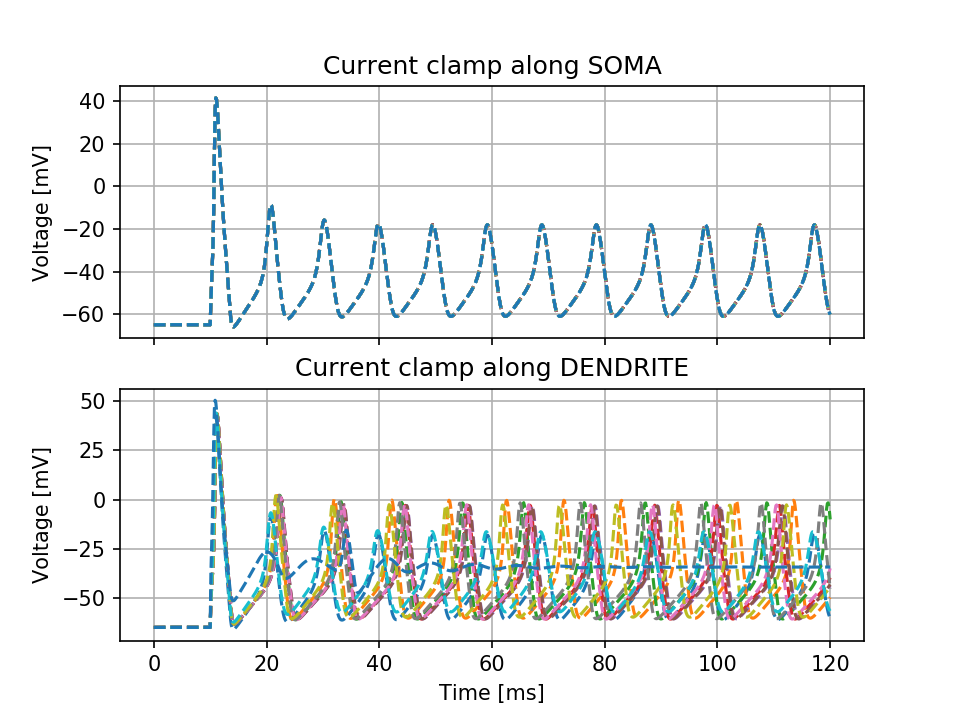

In [88]:
# exercise_4_1()
exercise_4_2(120)